In [41]:
import os
import glob
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import lightly
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np

In [42]:
path_to_data = '/home/jcejudo/interface_dataset/visualization/static/training_data'
dest_path = '/home/jcejudo/visual_recommendation'
num_workers = 2
batch_size = 64
seed = 1
max_epochs = 20
input_size = 64
num_ftrs = 32

# %%
# Let's set the seed for our experiments
pl.seed_everything(seed)



collate_fn = lightly.data.SimCLRCollateFunction(
    input_size=input_size,
    vf_prob=0.5,
    rr_prob=0.5,
    cj_prob=0.0,
    random_gray_scale=0.0
)

# We create a torchvision transformation for embedding the dataset after 
# training
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

dataset_train_simclr = lightly.data.LightlyDataset(
    input_dir=path_to_data
)

dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_data,
    transform=test_transforms
)


dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

Global seed set to 1


In [43]:
# %%
# Create the SimCLR model
# -----------------------
# Create a ResNet backbone and remove the classification head


resnet = lightly.models.ResNetGenerator('resnet-18')
last_conv_channels = list(resnet.children())[-1].in_features
backbone = nn.Sequential(
    *list(resnet.children())[:-1],
    nn.Conv2d(last_conv_channels, num_ftrs, 1),
    nn.AdaptiveAvgPool2d(1)
)

# create the SimCLR model using the newly created backbone
model = lightly.models.SimCLR(backbone, num_ftrs=num_ftrs)

# %%
# We now use the SelfSupervisedEmbedding class from the embedding module.
# First, we create a criterion and an optimizer and then pass them together
# with the model and the dataloader.
criterion = lightly.loss.NTXentLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
encoder = lightly.embedding.SelfSupervisedEmbedding(
    model,
    criterion,
    optimizer,
    dataloader_train_simclr
)

# %% 
# use a GPU if available
gpus = 1 if torch.cuda.is_available() else 0
encoder.train_embedding(gpus=gpus, 
                        progress_bar_refresh_rate=100,
                        max_epochs=max_epochs)

# %%
# Now, let's make sure we move the trained model to the gpu if we have one
device = 'cuda' if gpus==1 else 'cpu'
encoder = encoder.to(device)

# %%
# We can use the .embed method to create an embedding of the dataset. The method
# returns a list of embedding vectors as well as a list of filenames.
embeddings, labels, fnames = encoder.embed(dataloader_test, device=device)
embeddings = normalize(embeddings)

model_filename = 'model.pth'
torch.save(encoder.model.state_dict(),os.path.join(dest_path,model_filename))

import lightly.utils.io as io
embeddings_filename = 'embeddings.csv'
io.save_embeddings(os.path.join(dest_path,embeddings_filename), embeddings, labels, fnames)





GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | model     | SimCLR     | 11.2 M
1 | criterion | NTXentLoss | 0     
-----------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params


Epoch 0:   0%|          | 0/291 [00:00<?, ?it/s] 

/opt/miniconda3/envs/lightly_env/lib/python3.9/site-packages/PIL/Image.py:2847: DecompressionBombWarning: Image size (149839008 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Epoch 1:  34%|███▍      | 100/291 [01:32<02:55,  1.09it/s, loss=3.28, v_num=9]

  0%|          | 0/292 [00:00<?, ?it/s]

  0%|          | 0/292 [00:02<?, ?it/s]


KeyboardInterrupt: 

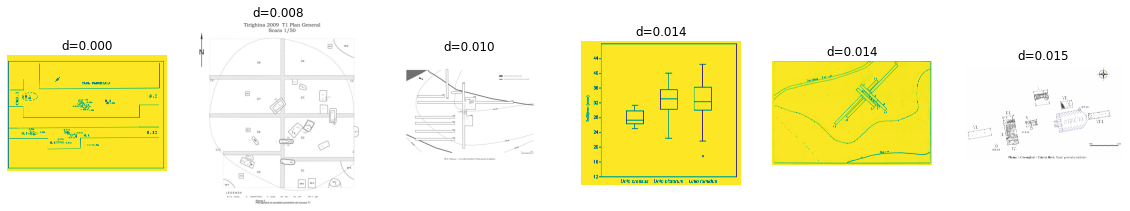

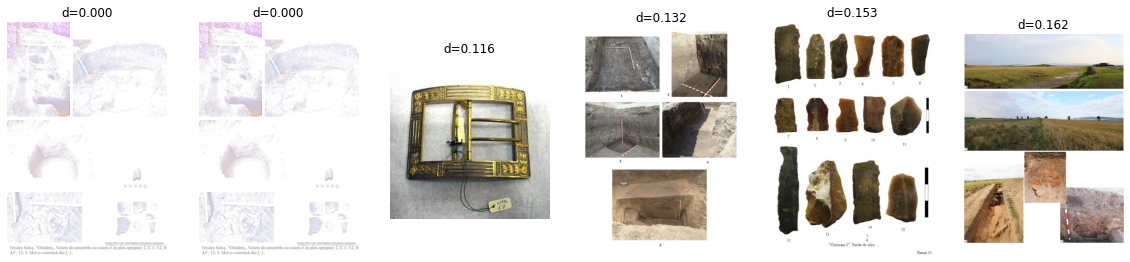

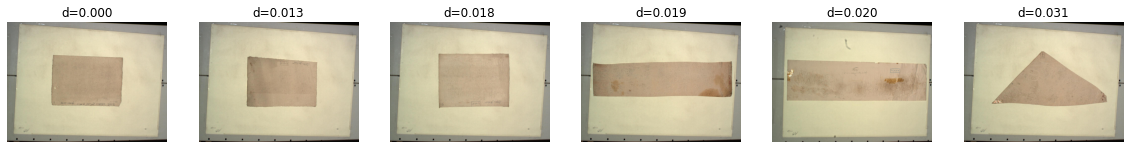

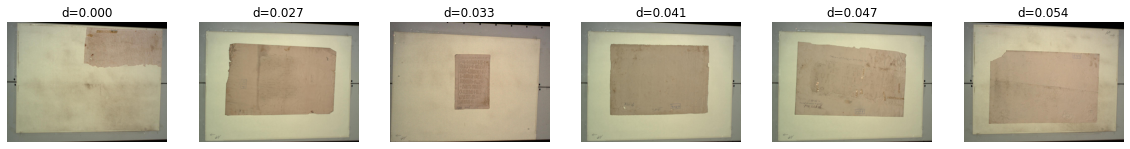

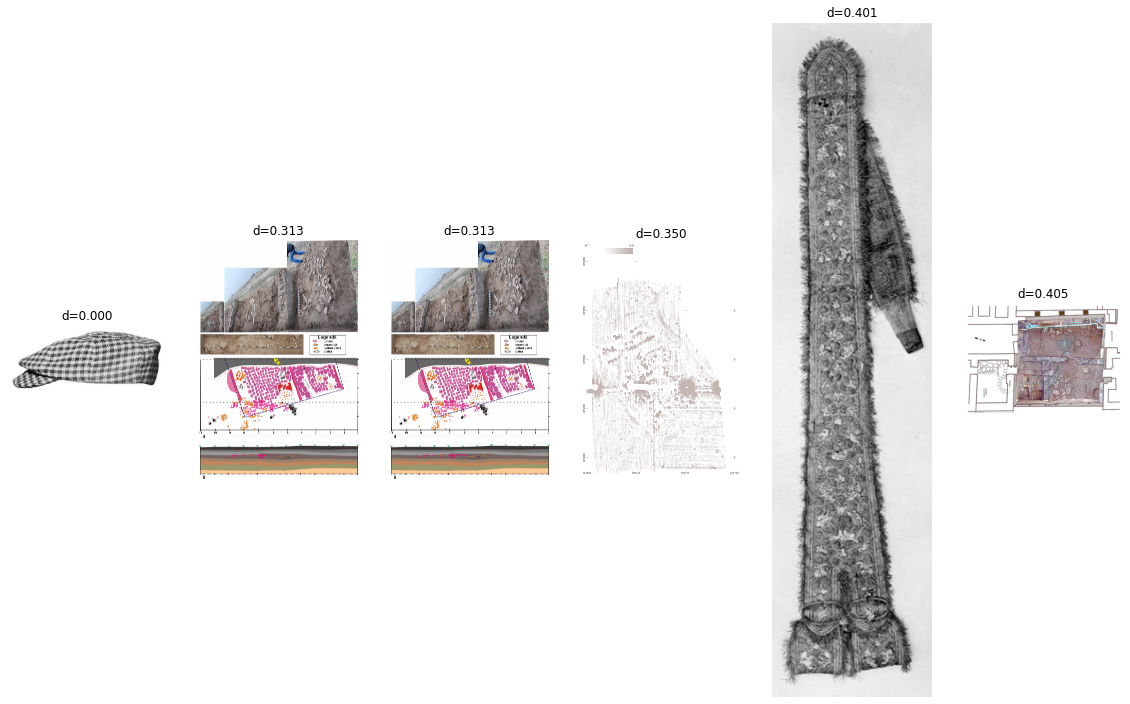

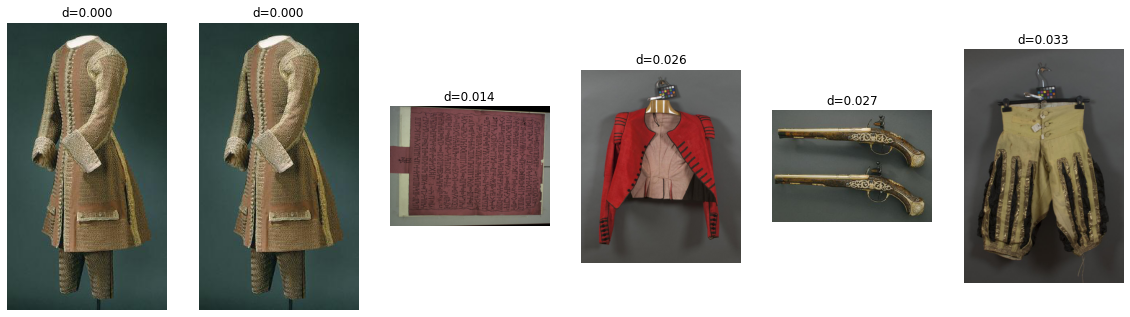

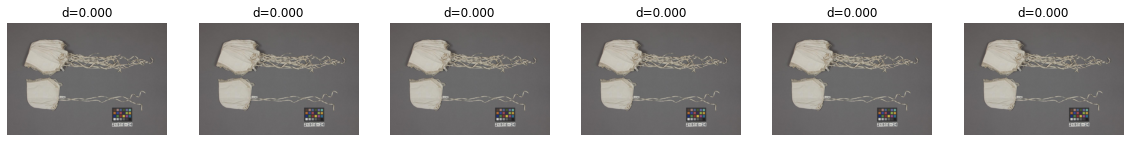

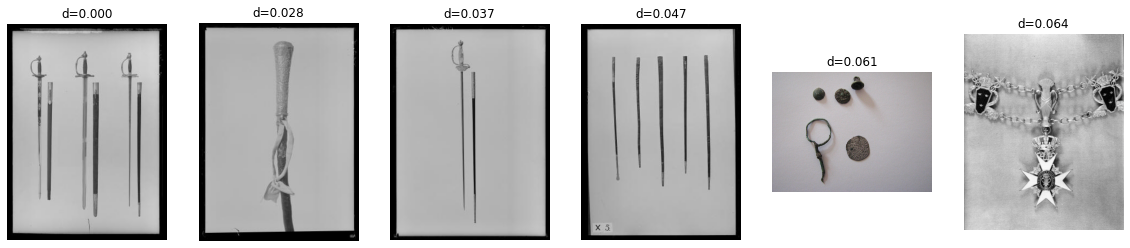

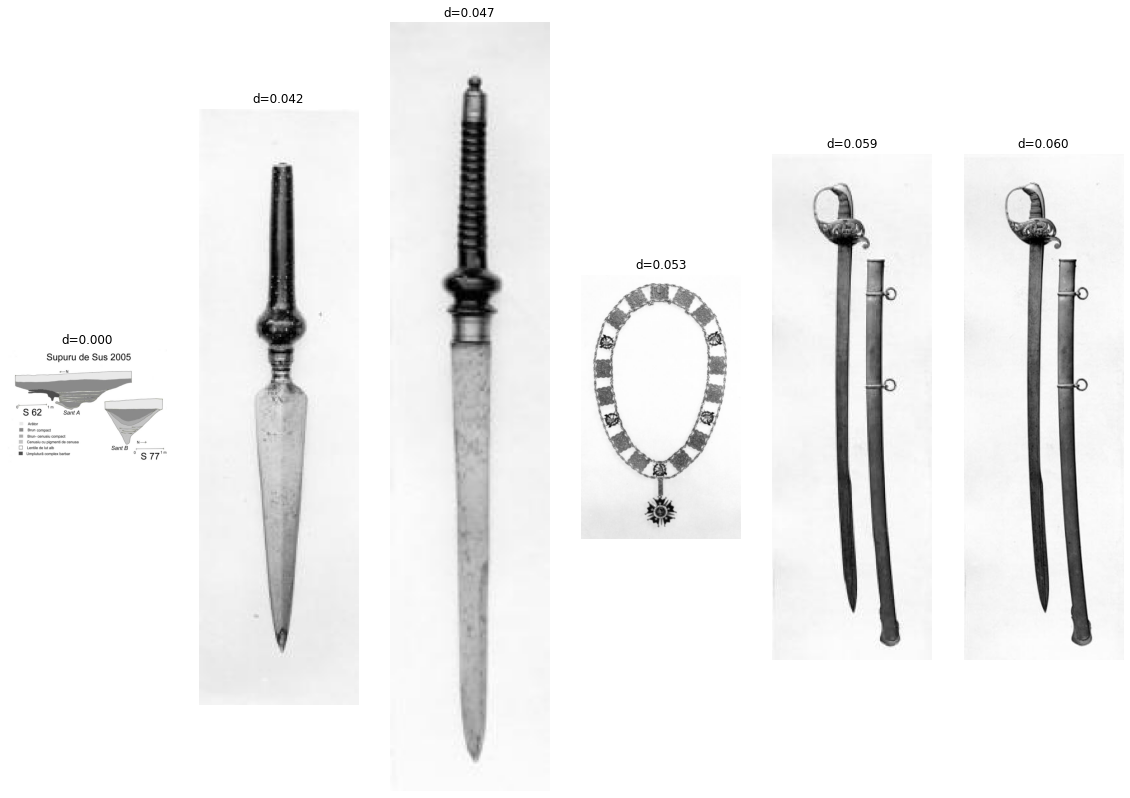

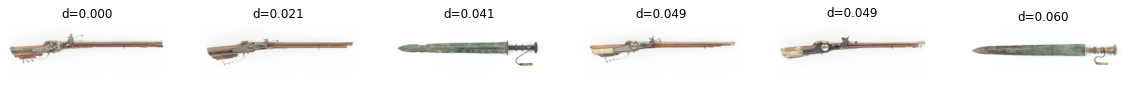

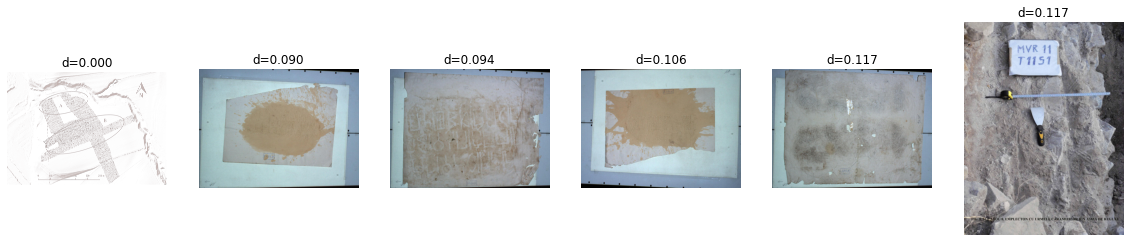

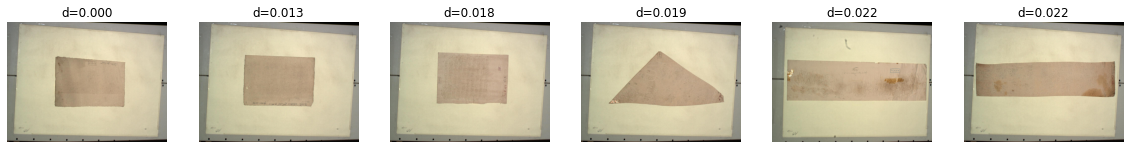

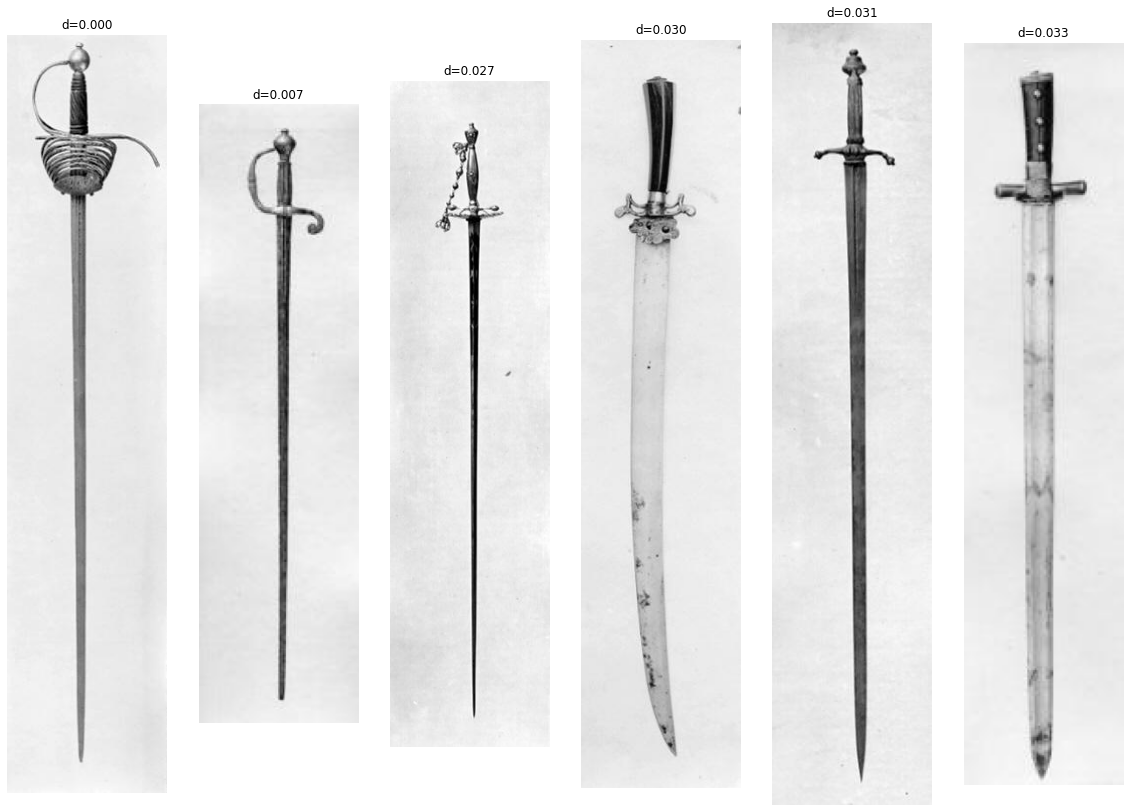

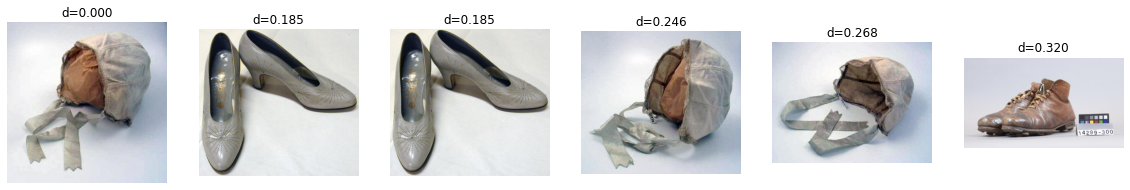

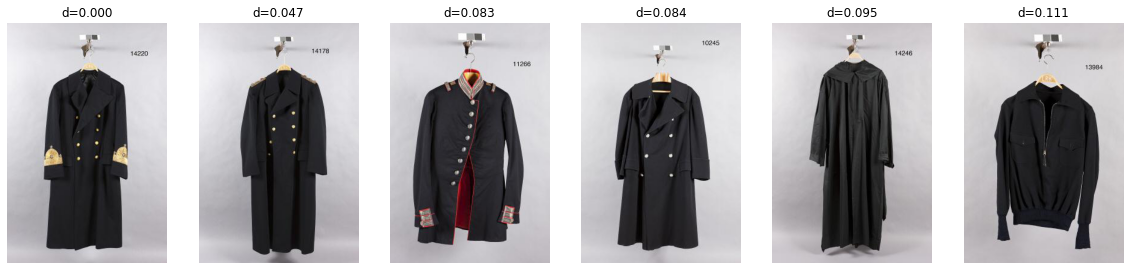

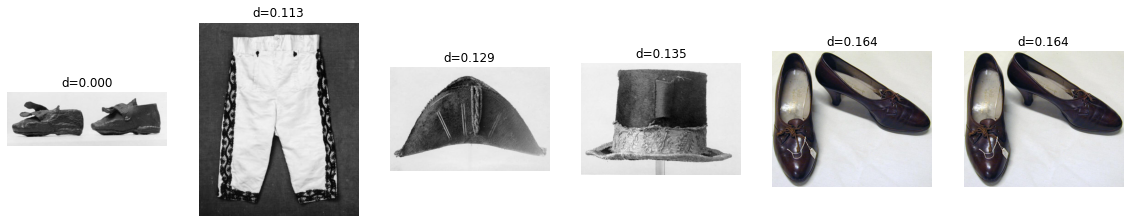

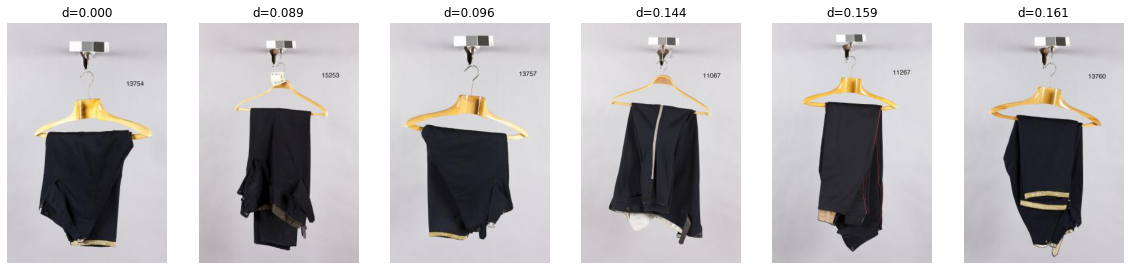

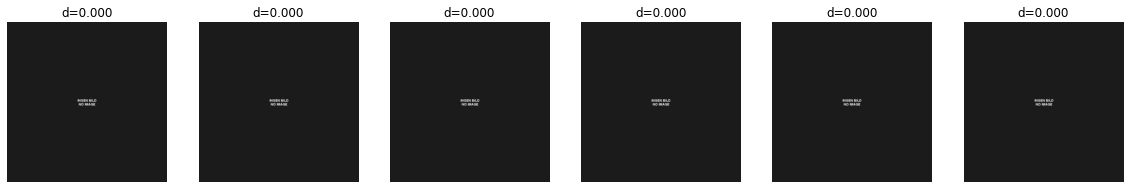

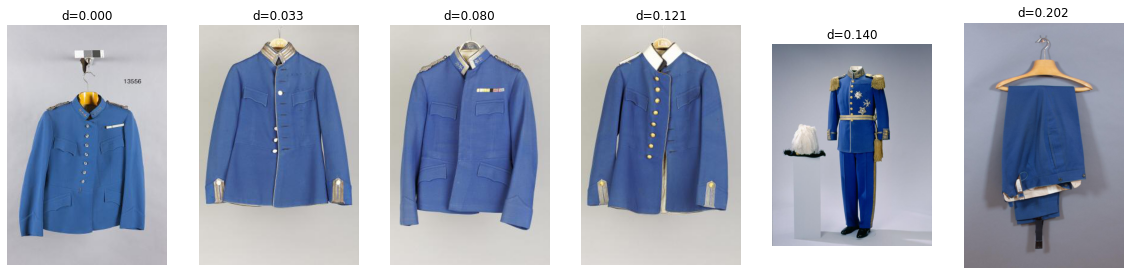

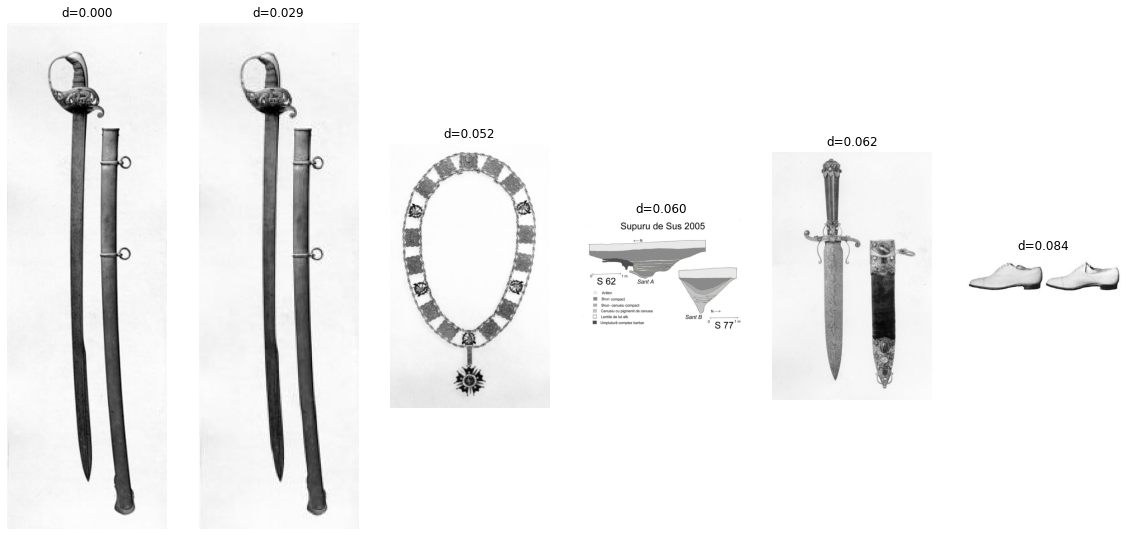

In [5]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array
    """
    img = Image.open(filename)
    return np.asarray(img)

def plot_knn_examples(embeddings, n_neighbors=5, num_examples=15):
    """Plots multiple rows of random images with their nearest neighbors
    """
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure(figsize = (20,20))
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, fnames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f'd={distances[idx][plot_x_offset]:.3f}')
            # let's disable the axis
            plt.axis('off')
            
plot_knn_examples(embeddings,n_neighbors=6, num_examples=20)


In [44]:
import lightly.utils.io as io


n_neighbors = 3
model_path = '/home/jcejudo/visual_recommendation/model.pth'
embeddings_path = '/home/jcejudo/visual_recommendation/embeddings.csv'


#load embeddings

embeddings, labels, filenames = io.load_embeddings(embeddings_path)


nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
distances, indices = nbrs.kneighbors(embeddings)

#load model


resnet = lightly.models.ResNetGenerator('resnet-18')
last_conv_channels = list(resnet.children())[-1].in_features
backbone = nn.Sequential(
    *list(resnet.children())[:-1],
    nn.Conv2d(last_conv_channels, num_ftrs, 1),
    nn.AdaptiveAvgPool2d(1)
)

model = lightly.models.SimCLR(backbone, num_ftrs=num_ftrs)
criterion = lightly.loss.NTXentLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
encoder = lightly.embedding.SelfSupervisedEmbedding(
    model,
    criterion,
    optimizer,
    dataloader_train_simclr
)

encoder.model.load_state_dict(torch.load(model_path))
encoder.model.eval()

SimCLR(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): Bat

In [30]:
filenames

['archaeological_site/__placeholder__2020716__placeholder___INP_RAN_1188_02.jpg',
 'archaeological_site/__placeholder__2020716__placeholder___INP_RAN_119215_02.jpg',
 'archaeological_site/__placeholder__2020716__placeholder___INP_RAN_119215_03.jpg',
 'archaeological_site/__placeholder__2020716__placeholder___INP_RAN_120735_01.jpg',
 'archaeological_site/__placeholder__2020716__placeholder___INP_RAN_12108_02.jpg',
 'archaeological_site/__placeholder__2020716__placeholder___INP_RAN_12153_01.jpg',
 'archaeological_site/__placeholder__2020716__placeholder___INP_RAN_121625_01.jpg',
 'archaeological_site/__placeholder__2020716__placeholder___INP_RAN_122766_01.jpg',
 'archaeological_site/__placeholder__2020716__placeholder___INP_RAN_124108_01.jpg',
 'archaeological_site/__placeholder__2020716__placeholder___INP_RAN_127055_02.jpg',
 'archaeological_site/__placeholder__2020716__placeholder___INP_RAN_128150_01.jpg',
 'archaeological_site/__placeholder__2020716__placeholder___INP_RAN_129736_01.jp

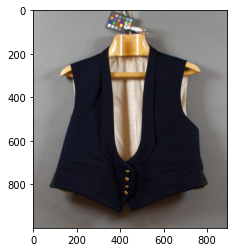

clothing/__placeholder__2064105__placeholder__Museu_ProvidedCHO_Livrustkammaren_47011.jpg


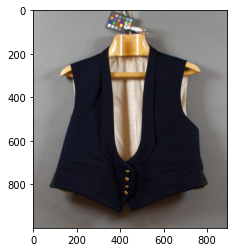

clothing/__placeholder__2064105__placeholder__Museu_ProvidedCHO_Livrustkammaren_50412.jpg


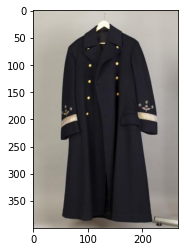

clothing/__placeholder__2064105__placeholder__Museu_ProvidedCHO_Livrustkammaren_49401.jpg


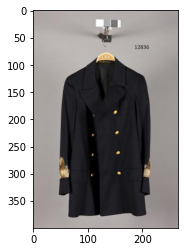

In [37]:
from PIL import Image
import torch
import matplotlib.pyplot as plt


input_size = 64
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

#load an image

data_path = '/home/jcejudo/rd-img-classification-pilot/training_data/getty'

filename = 'clothing/__placeholder__2064105__placeholder__Museu_ProvidedCHO_Livrustkammaren_47011.jpg'
idx = filenames.index(filename)

img = Image.open(os.path.join(data_path,filename)).convert('RGB')
img_tensor = test_transforms(img)
#apply the encoder
img_embed = encoder.model(torch.unsqueeze(img_tensor,0))


plt.imshow(img)
plt.show()

for neighbor_idx in indices[idx]:
    print(fnames[neighbor_idx])
    img = Image.open(os.path.join(data_path,fnames[neighbor_idx])).convert('RGB')
    plt.imshow(img)
    plt.show()
    


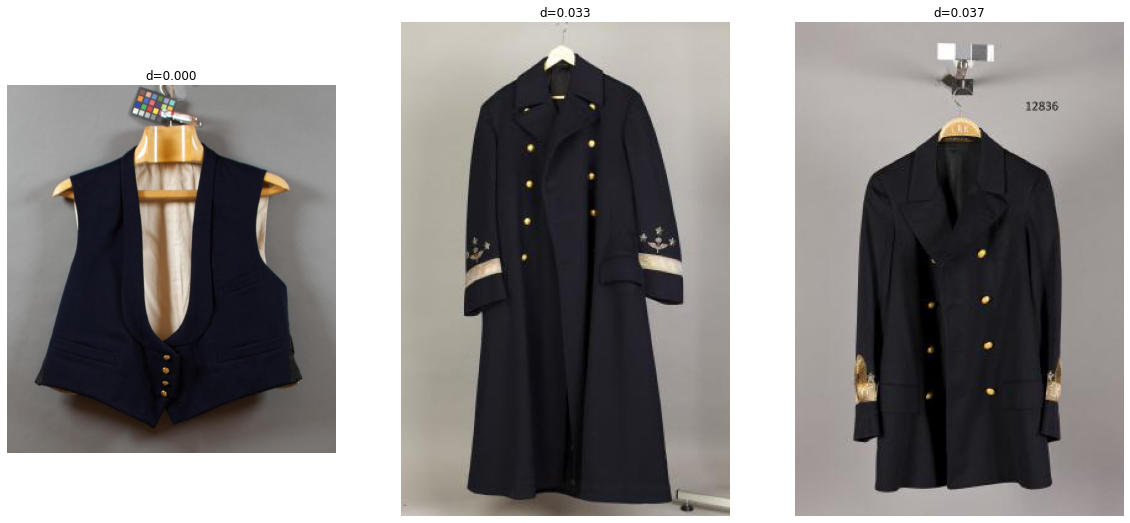

In [32]:
#find nearest neighbours

fig = plt.figure(figsize = (20,20))
# loop through their nearest neighbors
for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
    # add the subplot
    ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
    # get the correponding filename for the current index
    fname = os.path.join(path_to_data, fnames[neighbor_idx])
    # plot the image
    plt.imshow(get_image_as_np_array(fname))
    # set the title to the distance of the neighbor
    ax.set_title(f'd={distances[idx][plot_x_offset]:.3f}')
    # let's disable the axis
    plt.axis('off')